In [1]:
import numpy as np
import pandas as pd
import pickle

from matplotlib import pyplot as plt

import hist
import scipy
from scipy import optimize

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/df_test_sample_hard_scattering/"
savedir = "/home/chardong/y_identification/Venv/save_plots/"

In [3]:
df = pd.read_pickle(datadir+"df_test_combined_sample_hard_scattering_skim30.pkl")
df.columns
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score
0,51.956734,2.267797,-1.499033,49.392670,3,48.548934,0.0,31.5,False,False,12.533671,2.266477,0.998945,0.001055,0.998116,0.001884
1,34.364429,-1.958636,1.959331,317.343506,1,38.855491,0.0,47.5,False,False,26.214190,-1.961529,0.894247,0.105753,0.886565,0.113435
2,39.007401,0.172711,-0.628337,9999.000000,0,554.386153,1.0,29.5,True,True,37.140778,0.202515,0.026289,0.973711,0.031017,0.968983
3,86.679977,0.162386,2.113541,9999.000000,0,40.708948,1.0,22.5,True,True,86.595421,0.162440,0.029999,0.970001,0.030308,0.969692
4,281.008636,-0.796674,0.281347,9999.000000,0,0.283104,1.0,28.5,True,True,282.742554,-0.796599,0.020765,0.979235,0.022537,0.977463


In [4]:
# y_eta
edges_eta= [0 , 0.6  ,  0.8  ,  1.15  ,  1.37  , 1.52 ,  1.81  ,  2.01  ,  2.37 ]

# evt-mu
#edges_mu = [5, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 40]
edges_mu = [0., 16.,18., 20., 22., 24., 26., 28., 30., 32.,
               34., 36., 38., 40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.,
               62., 64.,66., 68., 100]

# Créer des axes de structure de bins
axis_eta  = hist.axis.Variable(edges_eta,    name="eta", label=r"$\eta$")
axis_mu = hist.axis.Variable(edges_mu, name='evt_mu', label=r"$evt_\mu$ [GeV]")

In [5]:
# Preselection on photon passin Loose cut-based selection 
df = df.query('y_IsLoose == 1')

In [6]:
# Adding column with absolute eta value, assuming symmetry
df['y_abs_eta'] = np.abs(df['y_eta'])
#df.head()

In [7]:

# Nouvelles colones eta_bin_.. dans le df assignant chaque valeur de y_abs_eta à un bin de l'histograme axis_... 
df = df.assign(eta_bin_sig=axis_eta.index(df['y_abs_eta']))
df = df.assign(eta_bin_bkg=axis_eta.index(df['y_abs_eta']))

# Assiging indices correspoding to bins to each event in dataset
df = df.assign(mu_bin_sig=axis_mu.index(df['evt_mu']))       #Mapper les valeur de evt_mu aux bins définis par axis_mu.
df = df.assign(mu_bin_bkg=axis_mu.index(df['evt_mu']))


In [8]:
df_sig = df.query('truth_label==1')
df_bkg = df.query('truth_label==0')

df_sig_tight = df_sig[(df_sig["y_IsTight"]==1)]  #bouléen
df_bkg_tight = df_bkg[(df_bkg["y_IsTight"]==1)]

### Compute efficiency and rejection for cut-based Tight identification

In [9]:
# Histograms and Axes pour `mu` et 'eta'
den_sig = hist.Hist(axis_eta, axis_mu).fill(df_sig["y_abs_eta"], df_sig["evt_mu"])   #before cat-base
den_bkg = hist.Hist(axis_eta, axis_mu).fill(df_bkg["y_abs_eta"], df_bkg["evt_mu"])

num_sig_tight = hist.Hist(axis_eta, axis_mu).fill(df_sig_tight["y_abs_eta"], df_sig_tight["evt_mu"])   #after cut-base
num_bkg_tight = hist.Hist(axis_eta, axis_mu).fill(df_bkg_tight["y_abs_eta"], df_bkg_tight["evt_mu"])

eff_sig_tight = (num_sig_tight/den_sig).values()
efferr_sig_tight = np.sqrt(eff_sig_tight*(1.-eff_sig_tight)/den_sig.values()) # binomial uncertainty on efficiency

eff_bkg_tight = (num_bkg_tight/den_bkg).values()
efferr_bkg_tight = np.sqrt(eff_bkg_tight*(1.-eff_bkg_tight)/den_bkg.values()) # binomial uncertainty on efficiency


In [10]:
eff_sig_tight.shape

(8, 28)

In [11]:
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg
2,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.202515,0.026289,0.973711,0.031017,0.968983,0.172711,0,0,7,7
3,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.162440,0.029999,0.970001,0.030308,0.969692,0.162386,0,0,4,4
4,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,-0.796599,0.020765,0.979235,0.022537,0.977463,0.796674,1,1,7,7
6,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,-1.346292,0.027042,0.972958,0.030241,0.969759,1.329535,3,3,14,14
7,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.836874,0.019330,0.980670,0.022041,0.977959,0.836519,2,2,20,20


# BDT working point optimization
Optimiser le point de fonctionnement d'un modèle BDT (Boosted Decision Trees) en calculant un seuil de score qui atteint une efficacité cible donnée.

In [12]:
def compute_eff_BDT(df, threshold):
    '''Return efficienty of a given selection on BDT score'''
    r = (df['Original_signal_score'] > threshold).sum() / len(df) # 'threshold' -> Le seuil du score BDT utilisé pour déterminer 
                                                                    # si un événement est sélectionné.

#  (df['Addevtmu_signal_score'] > threshold) : 
#  Crée une série booléenne où chaque élément est True si le score BDT de l'événement correspondant est supérieur au seuil donné,
#  sinon False.
#  .sum() : 
#  Compte le nombre de True dans la série booléenne, ce qui équivaut au nombre d'événements passant le seuil.
#  /len(df) : 
#  Pour obtenir l'efficacité de la sélection.  
    
    return r   # Efficacité de la sélection.

Trouve le seuil de score BDT qui permet d'atteindre une efficacité cible spécifique:

In [13]:
def find_cut_with_root_scalar(df, target_efficiency):
    '''Find selection on BDT score correponsing to target effeciency'''
    
#  scipy.optimize.root_scalar(....) :
#  Fonction de SciPy qui cherche une racine d'une fonction univariée. Ici, elle cherche le seuil x où l'efficacité de 
#  sélection est égale à l'efficacité cible.  
  
    r = scipy.optimize.root_scalar(                
        lambda x: compute_eff_BDT(df, x) - target_efficiency, bracket=(0., 1.0), #  Scores BDT sont normalisés entre 0 et 1.
        
#  lambda x: compute_eff_BDT(df, x) - target_efficiency :
#  Fonction anonyme (lambda) qui calcule la différence entre l'efficacité obtenue pour un seuil donné x et l'efficacité cible. 
#  Cette fonction est utilisée pour trouver la racine (c'est-à-dire le seuil où la différence est zéro).
        
        method='brenth', options={'xtol': 1E-5, 'maxiter': 50}
    )

#  method='brenth' : 
#  méthode sécurisée qui combine la méthode de la bissection, la méthode des cordes et l'inversion quadratique.
    
#  'xtol': 1E-5, 'maxiter': 50 :
#   Définit la tolérance sur la solution (précision) et le nombre maximum d'itérations pour trouver la racine. 
    
    return r.root

# r.root est l'attribut de l'objet résultat retourné par root_scalar contenant la solution trouvée.

In [14]:
df_bkg_indexed = df_bkg.set_index(['mu_bin_bkg', 'eta_bin_bkg']).sort_index()

In [15]:
bdt_cut_same_background_efficiency_tight = {} # store optimal BDT thresholds

for (ieta, imu), eff_tight in np.ndenumerate(eff_bkg_tight): 
    # select subsample of events corresponding to the current (eta, mu) bin
    
    df_bin = df_bkg_indexed.loc[imu, ieta] # using indexed df to speedup selection
    
    # find and store optimal BDT selection for current bin
    cut_BDT = find_cut_with_root_scalar(df_bin, target_efficiency=eff_tight)
    bdt_cut_same_background_efficiency_tight[imu, ieta] = cut_BDT

bdt_cut_same_background_efficiency_tight = pd.Series(bdt_cut_same_background_efficiency_tight).sort_index()
bdt_cut_same_background_efficiency_tight.index.names = ['mu_bin_bkg', 'eta_bin_bkg']

bdt_cut_same_background_efficiency_tight

mu_bin_bkg  eta_bin_bkg
0           0              0.778791
            1              0.790025
            2              0.717798
            3              0.636897
            4              0.607659
                             ...   
27          3              0.640862
            4              0.714286
            5              0.701179
            6              0.830710
            7              0.700125
Length: 224, dtype: float64

In [16]:
df = df.merge(bdt_cut_same_background_efficiency_tight.rename('BDTcut_samebkgeff_tight'), 
             on=['mu_bin_bkg', 'eta_bin_bkg'], how="left")
df = df.assign(pass_BDTcut_samebkgeff_tight = df['Original_signal_score'] > df['BDTcut_samebkgeff_tight'])

In [17]:
df.drop('BDTcut_samebkgeff_tight',axis=1,inplace=True)

In [18]:
df.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg,pass_BDTcut_samebkgeff_tight
0,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.026289,0.973711,0.031017,0.968983,0.172711,0,0,7,7,True
1,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.029999,0.970001,0.030308,0.969692,0.162386,0,0,4,4,True
2,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,0.020765,0.979235,0.022537,0.977463,0.796674,1,1,7,7,True
3,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,0.027042,0.972958,0.030241,0.969759,1.329535,3,3,14,14,True
4,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.019330,0.980670,0.022041,0.977959,0.836519,2,2,20,20,True


In [19]:
df_sig.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,y_truth_eta,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg
2,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.202515,0.026289,0.973711,0.031017,0.968983,0.172711,0,0,7,7
3,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.162440,0.029999,0.970001,0.030308,0.969692,0.162386,0,0,4,4
4,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,-0.796599,0.020765,0.979235,0.022537,0.977463,0.796674,1,1,7,7
6,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,-1.346292,0.027042,0.972958,0.030241,0.969759,1.329535,3,3,14,14
7,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.836874,0.019330,0.980670,0.022041,0.977959,0.836519,2,2,20,20


### Compute efficiency and rejection for BDT working point

In [20]:
df_sig = df.query('truth_label == 1')
df_bkg = df.query('truth_label == 0')

In [21]:
df_sig.head()

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,...,Original_background_score,Original_signal_score,Addevtmu_background_score,Addevtmu_signal_score,y_abs_eta,eta_bin_sig,eta_bin_bkg,mu_bin_sig,mu_bin_bkg,pass_BDTcut_samebkgeff_tight
0,39.007401,0.172711,-0.628337,9999.0,0,554.386153,1.0,29.5,True,True,...,0.026289,0.973711,0.031017,0.968983,0.172711,0,0,7,7,True
1,86.679977,0.162386,2.113541,9999.0,0,40.708948,1.0,22.5,True,True,...,0.029999,0.970001,0.030308,0.969692,0.162386,0,0,4,4,True
2,281.008636,-0.796674,0.281347,9999.0,0,0.283104,1.0,28.5,True,True,...,0.020765,0.979235,0.022537,0.977463,0.796674,1,1,7,7,True
3,59.986805,-1.329535,1.144537,9999.0,0,94.620789,1.0,42.5,True,False,...,0.027042,0.972958,0.030241,0.969759,1.329535,3,3,14,14,True
4,401.259369,0.836519,-1.640876,9999.0,0,0.639481,1.0,54.5,True,True,...,0.019330,0.980670,0.022041,0.977959,0.836519,2,2,20,20,True


In [22]:
#num and efficiency for the BDT

df_sig_bdt = df_sig.query('pass_BDTcut_samebkgeff_tight')
num_sig_bdt = hist.Hist(axis_eta, axis_mu).fill(df_sig_bdt["y_abs_eta"], df_sig_bdt["evt_mu"])

df_bkg_bdt = df_bkg.query('pass_BDTcut_samebkgeff_tight')
num_bkg_bdt = hist.Hist(axis_eta, axis_mu).fill(df_bkg_bdt["y_abs_eta"], df_bkg_bdt["evt_mu"])

eff_sig_bdt = (num_sig_bdt / den_sig).values()
efferr_sig_bdt = np.sqrt(eff_sig_bdt * (1 - eff_sig_bdt) / den_sig.values())

eff_bkg_bdt = (num_bkg_bdt / den_bkg).values()
efferr_bkg_bdt = np.sqrt(eff_bkg_bdt * (1 - eff_bkg_bdt) / den_bkg.values())

In [23]:
# Convertir histogramme en listes ou arrays pour tracer avec matplotlib
mu = axis_mu.centers

In [24]:
print(len(mu))
print(len(eff_bkg_tight))
print(len(efferr_bkg_tight))

28
8
8


In [31]:
mu

array([ 8., 17., 19., 21., 23., 25., 27., 29., 31., 33., 35., 37., 39.,
       41., 43., 45., 47., 49., 51., 53., 55., 57., 59., 61., 63., 65.,
       67., 84.])

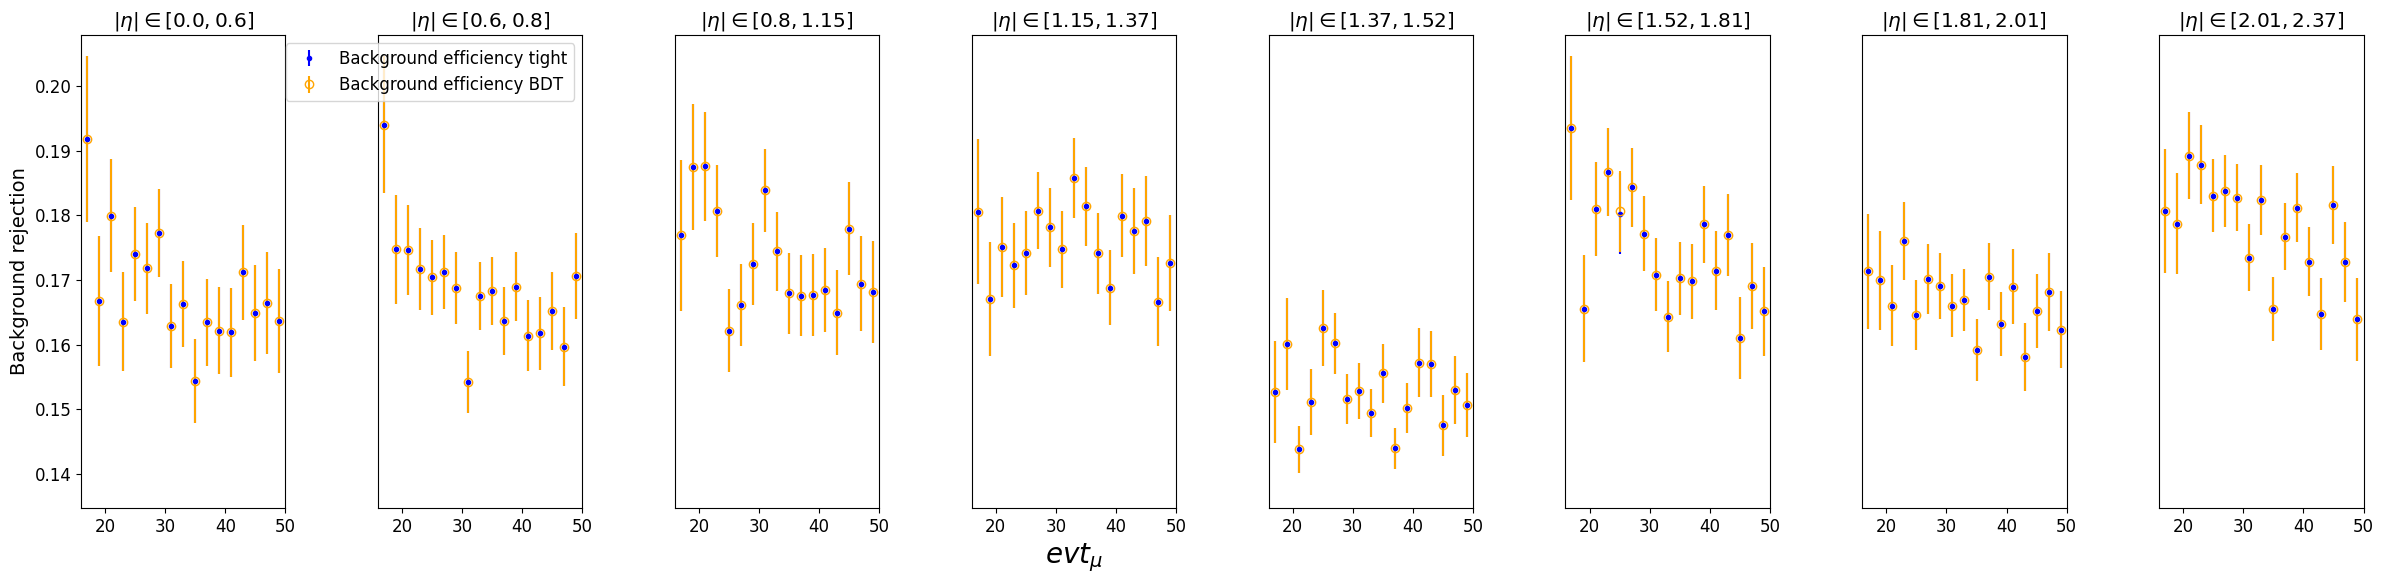

In [25]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(24,6))
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_bkg_tight[i],efferr_bkg_tight[i],
                   fmt=".", label='Background efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_bkg_bdt[i],efferr_bkg_bdt[i],
                   fmt="o", fillstyle='none', label='Background efficiency BDT', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0): ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    ax[i].set_xlim([16, 50])
    
ax[0].set_ylabel("Background rejection",  fontsize=14)
ax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle('BDTcut and CBT Background rejection efficiency', fontsize=26)

plt.tight_layout()

plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_rejection_MU_BinETA_BDTsansMU.pdf")
plt.show()

In [26]:
print(eff_sig_tight.shape)


(8, 28)


In [27]:
print(len(mu))
print(len(eff_sig_tight))
print(len(eff_sig_tight[i]))
print(len(efferr_sig_tight))
print(len(efferr_sig_tight[i]))

28
8
28
8
28


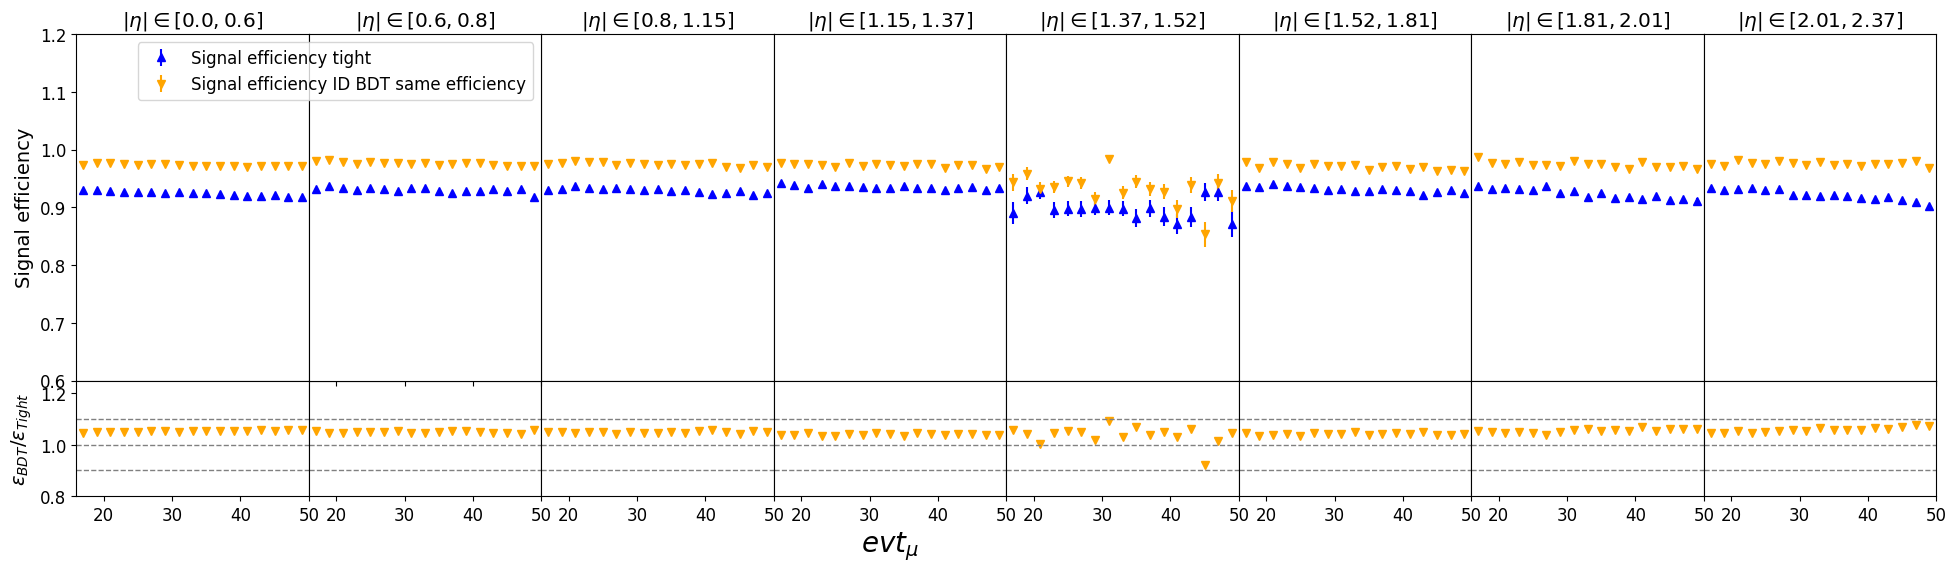

In [28]:
plt.rcParams.update({'font.size': 12})

fig, (ax, rax) = plt.subplots(nrows=2, ncols=8, figsize=(24,6), 
                              gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(wspace =.0, hspace=.0)

for i in range(8):
    ax[i].errorbar(mu, eff_sig_tight[i], efferr_sig_tight[i],
        fmt="^", label='Signal efficiency tight', color = 'blue')
    ax[i].errorbar(mu, eff_sig_bdt[i], efferr_sig_bdt[i],
        fmt="v", label='Signal efficiency ID BDT same efficiency', color = 'orange')    
    #ax[i].set_xscale('log')
    if (i!=0):
        ax[i].set_yticks([])
        
for i in range(8):
    text = r"$|\eta| \in [{}, {}]$".format(axis_eta.edges[i], axis_eta.edges[i + 1])
    ax[i].set(title = text)
    rax[i].plot(mu, eff_sig_bdt[i]/eff_sig_tight[i], 'v', color = 'orange')
    rax[i].axhline(y=1.0, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=1.1, color='grey', linestyle='--', linewidth=1)
    rax[i].axhline(y=0.9, color='grey', linestyle='--', linewidth=1)
    rax[i].set_xlim([16, 50])
    rax[i].set_ylim([0.8, 1.25])
    ax[i].set_ylim([0.6, 1.2])
    if (i!=0):
        rax[i].set_yticks([])
        
rax[0].set_ylabel(r'$\epsilon_{BDT}$/$\epsilon_{Tight}$', fontsize=14)
ax[0].set_ylabel("Signal efficiency",  fontsize=14)
rax[3].set_xlabel("$evt_{\mu}$",  fontsize=20)
ax[1].set_zorder(ax[1].get_zorder() + 1)
ax[1].legend(fontsize = 12)
fig.suptitle('BDTcut and CBT Signal selection efficiency', fontsize=26)



plt.savefig(savedir+"BDT_PID_reject_effi/BDT_PID_efficiency_MU_BinETA_BDTsansMU.pdf")
plt.show()